# Parsing CAM data (.json)

In [1]:
import json 
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
PATH = './sampleImg/'

In [3]:
with open(PATH+"liontiger.json") as json_file:
    json_data = json.load(json_file)

lion_data = np.array(json_data["lion"], dtype='uint8')
tiger_data = np.array(json_data["tiger"], dtype='uint8')

# heatmap 동작 확인

In [4]:
orig_heatmaps = []


img = cv2.imread(PATH+"lion_tiger.jpg")
height, width, _ = img.shape

# orig_heatmaps[0] = lion heatmap
orig_heatmaps.append(cv2.applyColorMap(cv2.resize(lion_data, (width, height)), cv2.COLORMAP_JET))

# orig_heatmaps[1] = tiger heatmap
orig_heatmaps.append(cv2.applyColorMap(cv2.resize(tiger_data, (width, height)), cv2.COLORMAP_JET))

# color channel별 heatmap 뽑기

In [5]:
# orig_img에서 (R, G, B) 세 가지 채널의 정보 중 특정 채널의 정보만 남겨서 넘김
def get_channel_image(orig_img, channel):
    channel = channel.upper()
    channel_img = orig_img.copy()
    if channel == 'R':
        channel_img[:, :, 0] = 0
        channel_img[:, :, 1] = 0
    elif channel == 'G':
        channel_img[:, :, 0] = 0
        channel_img[:, :, 2] = 0
    elif channel == 'B':
        channel_img[:, :, 1] = 0
        channel_img[:, :, 2] = 0

    return channel_img

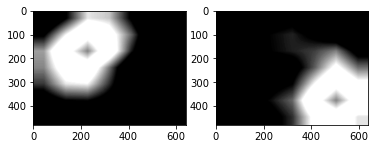

In [6]:
heatmaps = []
for index, orig_heatmap in enumerate(orig_heatmaps):
    # orig_heatmap에서 `R` 계열이 가장 중요한 feature 부분을 나타내므로 해당 정보만 사용
    heatmaps.append(get_channel_image(orig_heatmap, 'r'))
    
fig, ax = plt.subplots(nrows=1, ncols=len(heatmaps))
    
for index, heatmap in enumerate(heatmaps):
    # orig_heatmap의 R 채널 데이터를 gray scale로 출력
    ax[index].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY), cmap='gray')
    
plt.show()

# CAM 결과를 이용하여 Bounding Box 잡기

In [7]:
# color image를 gray scale로 바꾼 후, threshold를 적용함
# threshold는 고정 값으로 mean(min, max)
def get_grayscale_image_with_threshold(orig_img):
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    
    min_val = np.min(gray_img)
    max_val = np.max(gray_img)
    threshold = (min_val + max_val) / 2
    
    ret, gray_img = cv2.threshold(gray_img, threshold, 1, cv2.THRESH_BINARY)    

    return gray_img

In [8]:
# grayscale_mask 에서 1인 부분만 orig_img를 보여줌. 0인 부분은 검정색으로 보임
def get_masked_image(orig_img, gray_map):
    mask = cv2.cvtColor(gray_map, cv2.COLOR_GRAY2BGR)
    
    maskedRegion = np.where(mask == 1, orig_img, 0)
    
    return cv2.cvtColor(maskedRegion, cv2.COLOR_BGR2RGB)

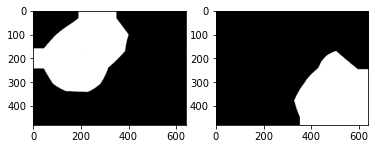

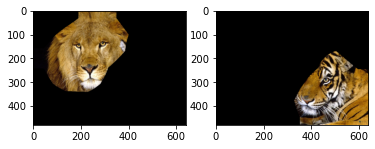

In [9]:
graymaps = []

for index, heatmap in enumerate(heatmaps):
    # gray scale img로 바꾸고, threshold 이상의 값만 binary로 살림
    graymaps.append(get_grayscale_image_with_threshold(heatmap))

# threshold가 적용된 graymap 결과 확인
fig, ax = plt.subplots(nrows=1, ncols=len(graymaps))
for index, graymap in enumerate(graymaps):
    ax[index].imshow(graymap, cmap="gray")
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=len(graymaps))
for index, graymap in enumerate(graymaps):
    ax[index].imshow(get_masked_image(img, graymap))
plt.show()

In [10]:
def get_contours(img_binary):
    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

In [11]:
def get_bounding_box(img_binary):
    bb = []
    
    contours = get_contours(img_binary)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        bb.append([x, y, w, h])
        
    return bb

In [12]:
def draw_bounding_box(bounding_box, img):
    tmp_img = img.copy()

    dim = np.array(bounding_box).ndim
    
    if dim == 2:
        for x, y, w, h in bounding_box:
            cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    elif dim == 3:
        for bb in bounding_box:
            for x, y, w, h in bb:
                cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    return cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

In [13]:
def get_image_of_compare_contour_and_bounding_box(img_binary, img):
    
    contours = get_contours(img_binary)
    
    tmp_img = img.copy()
    
    # draw contours - red
    for cnt in contours:
        cv2.drawContours(tmp_img, [cnt], 0, (0,0,255),3)
    
    # draw bounding box - green
    bb = get_bounding_box(img_binary)
    for x, y, w, h in bb:
        cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
        
    return cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

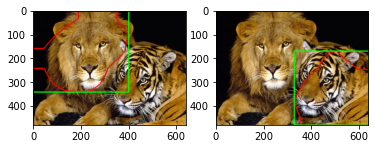

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=len(heatmaps))

for index, graymap in enumerate(graymaps):
    # contour 영역과 bounding box 비교
    ax[index].imshow(get_image_of_compare_contour_and_bounding_box(graymap, img))
    
plt.show()

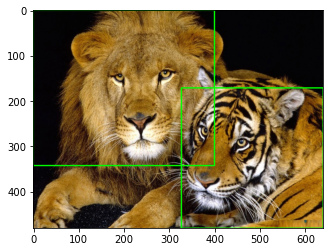

In [15]:
CAM_BB = []

for index, graymap in enumerate(graymaps):
    CAM_BB.append(get_bounding_box(graymap))

plt.imshow(draw_bounding_box(CAM_BB, img))

# Selective Search 결과와 CAM Bounding Box 비교

In [16]:
def cv2_selective_search(img, searchMethod='f'):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    
    if searchMethod == 'f':
        ss.switchToSelectiveSearchFast()
    elif searchMethod == 'q':
        ss.switchToSelectiveSearchQuality()
        
    regions = ss.process()
    
    return regions

num of all regions by ss: 2735


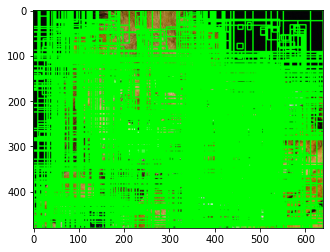

In [17]:
SS_BB = cv2_selective_search(img)

print(f'num of all regions by ss: {len(SS_BB)}')
plt.imshow(draw_bounding_box(SS_BB, img))

In [18]:
def get_iou(_bb1, _bb2, changeScale = False):
    if changeScale:
        # _bb1, _bb2 = [x, y, w, h]
        if len(_bb1) == 4 and len(_bb2) == 4:
            bb1 = {'x1':_bb1[0], 'y1':_bb1[1], 'x2':_bb1[0]+_bb1[2], 'y2':_bb1[1]+_bb1[3]}
            bb2 = {'x1':_bb2[0], 'y1':_bb2[1], 'x2':_bb2[0]+_bb2[2], 'y2':_bb2[1]+_bb2[3]}
        else:
            exit(0)
    else:
        # _bb1, _bb2 = ['x1':x1, 'x2':x2, 'y1':y1, 'y2':y2]
        bb1 = _bb1
        bb2 = _bb2
    
    
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [19]:
def get_candidate_bounding_box(SS_BB, CAM_BB):
    # SS_BB dim = 2
    # CAM_BB dim = 3
    
    bounding_box = []

    for ss_bb in SS_BB:
        for cam_bbs in CAM_BB:
            for cam_bb in cam_bbs:
                iou = get_iou(ss_bb, cam_bb, changeScale = True)
                if iou > 0.7:
                    bounding_box.append(ss_bb)
    return bounding_box

In [20]:
bounding_box = get_candidate_bounding_box(SS_BB, CAM_BB)

num of candidate bounding box: 18


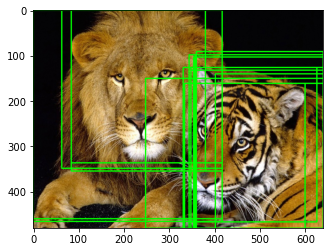

In [21]:
plt.imshow(draw_bounding_box(bounding_box, img))
print(f'num of candidate bounding box: {len(bounding_box)}')